In [167]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

In [168]:
transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),])
train_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)

In [171]:
valid_size = 0.2
batch_size = 64
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_index, valid_index = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                           sampler = train_sampler, num_workers = 0)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                          sampler = valid_sampler, num_workers = 0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                         num_workers = 0)

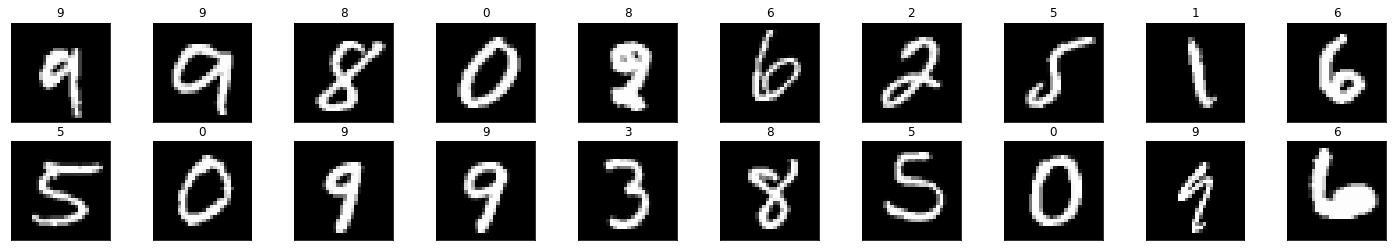

In [172]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images_np = images.numpy()
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images_np[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))

In [173]:
print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [174]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork,self).__init__()
        self.C1 = nn.Parameter(data=torch.zeros(6, 1, 5, 5), requires_grad=True)
        self.b1 = nn.Parameter(torch.zeros(6), requires_grad=True)
        nn.init.xavier_uniform_(self.C1, gain=nn.init.calculate_gain('relu'))
        
        self.C3 = nn.Parameter(torch.zeros(16, 6, 5, 5), requires_grad=True)
        self.b3 = nn.Parameter(torch.zeros(16), requires_grad=True)
        nn.init.xavier_uniform_(self.C3, gain=nn.init.calculate_gain('relu'))
        
        self.C5 = nn.Parameter(torch.zeros(120, 16, 5, 5), requires_grad=True)
        self.b5 = nn.Parameter(torch.zeros(120), requires_grad=True)
        nn.init.xavier_uniform_(self.C5, gain=nn.init.calculate_gain('relu'))
        
        self.F6 = nn.Parameter(torch.zeros(120, 84), requires_grad=True)
        self.b6 = nn.Parameter(torch.zeros(84), requires_grad=True)
        nn.init.xavier_uniform_(self.F6, gain=nn.init.calculate_gain('relu'))
        
        self.F7 = nn.Parameter(torch.zeros(84, 10), requires_grad=True)
        nn.init.xavier_uniform_(self.F7, gain=nn.init.calculate_gain('sigmoid'))
        
    def forward(self, x):
        n = x.shape[0]
        x = F.conv2d(x, self.C1, padding=2, bias=self.b1)
        x = F.relu(x)
        pooling = torch.ones(1, 1, 2, 2) * 0.25
        x1 = torch.zeros(n, 6, 14, 14)
        for i in range(6):
            x_temp = F.conv2d(x[:, i, :, :].unsqueeze(1), pooling, stride=2)
            x1[:, i, :, :] = x_temp.squeeze()
        x = x1
        
        x = F.conv2d(x, self.C3, bias=self.b3)
        x = F.relu(x)
        x1 = torch.zeros(n, 16, 5, 5)
        for i in range(16):
            x_temp = F.conv2d(x[:, i, :, :].unsqueeze(1), pooling, stride=2)
            x1[:, i, :, :] = x_temp.squeeze()
        x = x1
        
        x = F.conv2d(x, self.C5, bias=self.b5)
        x = F.relu(x)
        x = x.squeeze()
        x = x.mm(self.F6) + self.b6
        x1 = torch.zeros(n, 10)
        for i in range(10):
            x1[:, i] = ((x - self.F7[:, i])**2).sum(axis=1)
        x = x1
        return x

In [175]:
model = NeuralNetwork()
print(model)
criterion = nn.CrossEntropyLoss()
loss = criterion(model(images), labels)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
model.to('cpu')
print(loss.item())

NeuralNetwork()
2.4127612113952637


In [176]:
n_epochs = 50
valid_loss_min = np.Inf
train_losses = []
valid_losses = []
for epoch in range(n_epochs):
    train_loss = 0
    valid_loss = 0
    model.train()
    for data, label in train_loader:
        data = data.to('cpu')
        label = label.to('cpu')
        optimizer.zero_grad()
        pred = model(data)
        loss = criterion(pred, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    model.eval()
    for data,label in valid_loader:
        data = data.to('cpu')
        label = label.to('cpu')
        output = model(data)
        loss = criterion(output, label)
        valid_loss += loss.item()

    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))
    if epoch % 5 == 0 and epoch != 0:
        cont = input("Do you want to continue y/n")
        if cont == 'n':
            break
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.010498 	Validation Loss: 0.004717
Validation loss decreased (inf --> 0.004717).  Saving model ...
Epoch: 2 	Training Loss: 0.003937 	Validation Loss: 0.003321
Validation loss decreased (0.004717 --> 0.003321).  Saving model ...
Epoch: 3 	Training Loss: 0.002810 	Validation Loss: 0.002357
Validation loss decreased (0.003321 --> 0.002357).  Saving model ...
Epoch: 4 	Training Loss: 0.002184 	Validation Loss: 0.002087
Validation loss decreased (0.002357 --> 0.002087).  Saving model ...
Epoch: 5 	Training Loss: 0.001807 	Validation Loss: 0.001664
Validation loss decreased (0.002087 --> 0.001664).  Saving model ...
Epoch: 6 	Training Loss: 0.001574 	Validation Loss: 0.001550
Do you want to continue y/ny
Validation loss decreased (0.001664 --> 0.001550).  Saving model ...
Epoch: 7 	Training Loss: 0.001396 	Validation Loss: 0.001317
Validation loss decreased (0.001550 --> 0.001317).  Saving model ...
Epoch: 8 	Training Loss: 0.001256 	Validation Loss: 0.001241
Valid

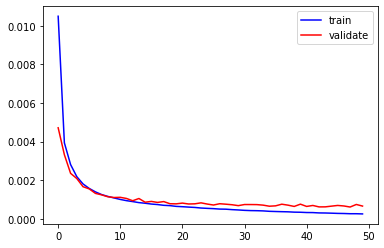

Accuracy of 1-th test: 1.0
Accuracy of 2-th test: 1.0
Accuracy of 3-th test: 1.0
Accuracy of 4-th test: 0.984375
Accuracy of 5-th test: 0.984375
Accuracy of 6-th test: 0.96875
Accuracy of 7-th test: 0.984375
Accuracy of 8-th test: 0.96875
Accuracy of 9-th test: 1.0
Accuracy of 10-th test: 0.984375


In [178]:
model.load_state_dict(torch.load('model.pt'))
plt.plot(np.arange(50),train_losses, color='b', label='train')
plt.plot(np.arange(50),valid_losses, color='r', label='validate')
plt.legend()
plt.show()
model.eval()
idx = 0
for data, label in test_loader:
    if idx >= 10:
        break
    idx += 1
    model.eval()
    output = model(data)
    pred = torch.argmax(output, 1)
    acc = pred == label
    acc = (acc.sum()/len(acc)).item()
    print("Accuracy of {}-th test: {}".format(idx, acc))

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3])


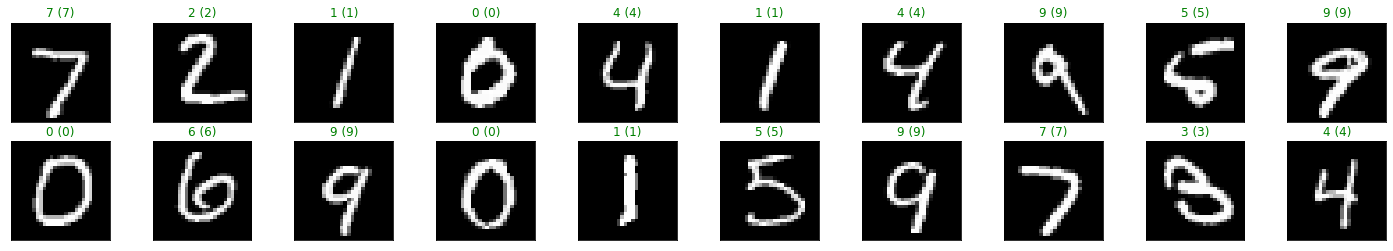

In [179]:
model.eval()
dataiter = iter(test_loader)
data, labels = dataiter.next()
output = model(data)
preds = torch.argmax(output, 1)
images = data.numpy()
fig = plt.figure(figsize=(25, 4))
print(labels)
print(preds)
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))